Attempting to load: simulation_results_best_hm_run/best_hm_run_results_20250622_155924_summary.csv
File loaded successfully! Shape: (1, 59)
Converting column: history_num_active_users...
  Successfully converted 'history_num_active_users'. Example (first 5 elements): [117, 134, 151, 176, 204]
Converting column: history_platform_attractiveness...
  Successfully converted 'history_platform_attractiveness'. Example (first 5 elements): [0.25858978228992446, 0.3127515459238531, 0.34187672657735696, 0.4017186509396527, 0.4146587767560184]
Converting column: history_avg_user_balance...
  Successfully converted 'history_avg_user_balance'. Example (first 5 elements): [102.24725239358561, 100.74617603317348, 98.80323201692335, 97.55044382851152, 96.1053241004803]

--- Details of the Simulation Run ---

Key Parameters Used:
  EMPIRICAL_CASE_SCENARIO: BaselineEngagement
  POTENTIAL_USER_POOL_SIZE: 20000
  SIMULATION_STEPS: 240
  COST_SUBMIT_FRESH_WORD: 6
  COST_INTERACT_STALE_WORD: 2
  POPULARITY_

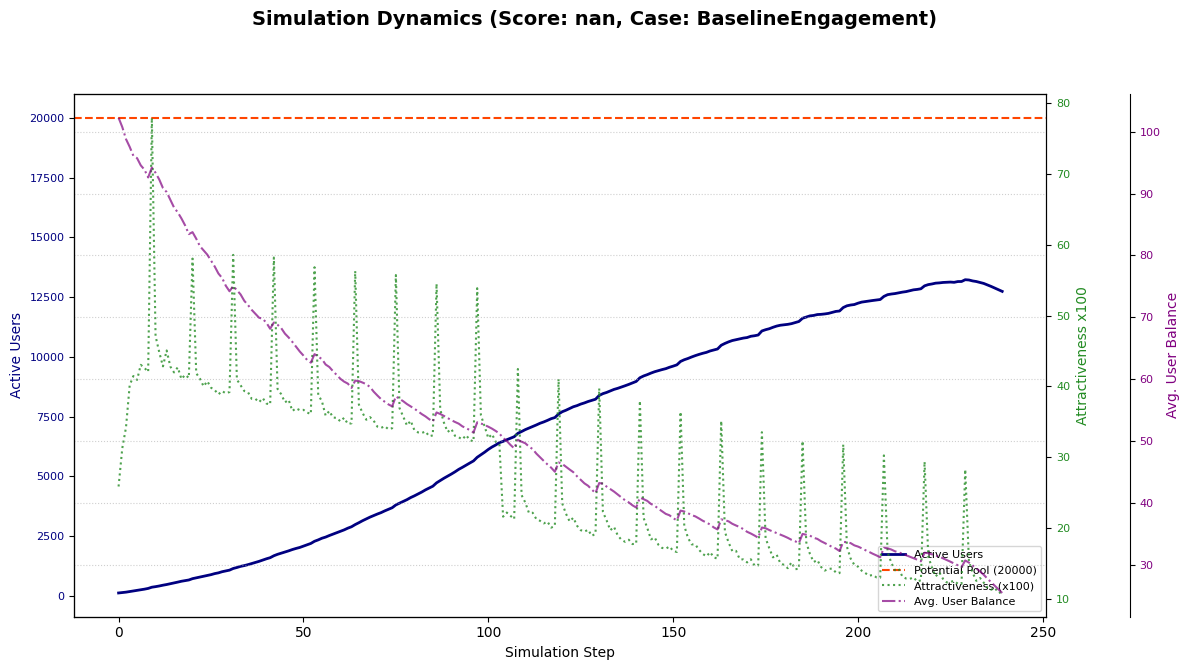


Analysis script finished.


In [4]:
import pandas as pd
import numpy as np
import ast # For safely evaluating string-represented lists/dicts
import re # For regular expressions
import matplotlib.pyplot as plt
import seaborn as sns # Kept for direct use if needed later
from datetime import datetime
import os

# --- Function to define Empirical Parameter Sets (keep as is, for context if needed) ---
# This function might not be directly used if all params are in 'params_config_copy'
# but it's good to have for understanding the case definitions.
def get_empirical_params_for_case(case_name):
    default_behavioral = {
        'INNOVATOR_PROB_NEW_CONCEPT': 0.60, 'INNOVATOR_PROB_AGREE': 0.30,
        'FOLLOWER_PROB_NEW_CONCEPT': 0.10, 'FOLLOWER_PROB_AGREE': 0.80,
        'BALANCED_PROB_NEW_CONCEPT': 0.35, 'BALANCED_PROB_AGREE': 0.55,
    }
    default_attractiveness = {
        'BASE_ATTRACTIVENESS_NO_USERS': 0.03,
        'BASE_ATTRACTIVENESS_WITH_USERS': 0.02,
        'ATTRACT_REWARD_SENSITIVITY': 0.3,
        'ATTRACT_ACTIVITY_SENSITIVITY': 0.4,
        'ATTRACT_FAIRNESS_SENSITIVITY': 0.15,
        'ATTRACT_BALANCE_SENSITIVITY': 0.2,
    }

    if case_name == "BaselineEngagement":
        params = default_behavioral.copy(); params.update(default_attractiveness)
        params.update({
            'USER_ARCHETYPES_DIST': {'Innovator': 0.2, 'Follower': 0.65, 'Balanced': 0.15},
            'FOLLOWER_POPULARITY_BIAS_FACTOR': 2.0,
            'USER_ACTIVITY_RATE_ON_PLATFORM': 0.7,
        })
        return params
    # Add other cases if needed, though for a single run analysis,
    # the EMPIRICAL_CASE_SCENARIO column in the CSV is the primary source.
    elif case_name == "HighEngagement_RewardDriven":
        params = default_behavioral.copy()
        params.update({
            'USER_ARCHETYPES_DIST': {'Innovator': 0.25, 'Follower': 0.55, 'Balanced': 0.2},
            'FOLLOWER_POPULARITY_BIAS_FACTOR': 1.8, 'USER_ACTIVITY_RATE_ON_PLATFORM': 0.8,
            'INNOVATOR_PROB_NEW_CONCEPT': 0.65, 'INNOVATOR_PROB_AGREE': 0.25,
            'FOLLOWER_PROB_NEW_CONCEPT': 0.15, 'FOLLOWER_PROB_AGREE': 0.75,
            'BALANCED_PROB_NEW_CONCEPT': 0.4, 'BALANCED_PROB_AGREE': 0.5,
            'BASE_ATTRACTIVENESS_NO_USERS': 0.05, 'BASE_ATTRACTIVENESS_WITH_USERS': 0.03,
            'ATTRACT_REWARD_SENSITIVITY': 0.5, 'ATTRACT_ACTIVITY_SENSITIVITY': 0.5,
            'ATTRACT_FAIRNESS_SENSITIVITY': 0.2, 'ATTRACT_BALANCE_SENSITIVITY': 0.3,
        })
        return params
    elif case_name == "CautiousFollowers_LowActivity":
        params = default_behavioral.copy()
        params.update({
            'USER_ARCHETYPES_DIST': {'Innovator': 0.1, 'Follower': 0.75, 'Balanced': 0.15},
            'FOLLOWER_POPULARITY_BIAS_FACTOR': 2.5, 'USER_ACTIVITY_RATE_ON_PLATFORM': 0.55,
            'INNOVATOR_PROB_NEW_CONCEPT': 0.5, 'INNOVATOR_PROB_AGREE': 0.4,
            'FOLLOWER_PROB_NEW_CONCEPT': 0.05, 'FOLLOWER_PROB_AGREE': 0.85,
            'BALANCED_PROB_NEW_CONCEPT': 0.25, 'BALANCED_PROB_AGREE': 0.65,
            'BASE_ATTRACTIVENESS_NO_USERS': 0.01, 'BASE_ATTRACTIVENESS_WITH_USERS': 0.005,
            'ATTRACT_REWARD_SENSITIVITY': 0.2, 'ATTRACT_ACTIVITY_SENSITIVITY': 0.2,
            'ATTRACT_FAIRNESS_SENSITIVITY': 0.1, 'ATTRACT_BALANCE_SENSITIVITY': 0.1,
        })
        return params
    else:
        print(f"Warning: Unknown empirical case_name '{case_name}'. Using BaselineEngagement defaults.")
        return get_empirical_params_for_case("BaselineEngagement")

# --- Robust Literal Eval for History Columns and Params Copy ---
def robust_literal_eval(val_str):
    if not isinstance(val_str, str):
        return val_str # Already parsed or not a string
    s = str(val_str).strip()
    s = re.sub(r'(?:np|numpy)\.float64\(([^)]+)\)', r'\1', s)
    s = re.sub(r'(?:np|numpy)\.array\(([^)]+)\)', r'\1', s) # Handle np.array() wrapper
    s = s.replace('nan', 'None').replace('inf', '"inf"').replace('-inf', '"-inf"')
    s = re.sub(r',\s*\]', ']', s)
    s = re.sub(r',\s*\}\)', '})', s)
    try:
        evaluated = ast.literal_eval(s)
        # Post-process for "inf" strings if it's a list
        if isinstance(evaluated, list):
            return [None if item == "inf" else (-float('inf') if item == "-inf" else item) for item in evaluated]
        return evaluated
    except (ValueError, SyntaxError) as e:
        # print(f"Robust literal_eval failed for '{s[:100]}...': {e}")
        return val_str # Return original string if parsing fails

# --- 1. Load and Prepare Data ---
# !!! IMPORTANT: Update this file_path to your actual CSV file !!!
# This should be the path to the CSV file you just provided.
file_path = "simulation_results_best_hm_run/best_hm_run_results_20250622_155924_summary.csv" # REPLACE THIS

print(f"Attempting to load: {file_path}")

try:
    df_results = pd.read_csv(file_path)
    print("File loaded successfully! Shape:", df_results.shape)
    
    if df_results.empty:
        raise ValueError("CSV file is empty.")
    if len(df_results) > 1:
        print(f"Warning: CSV contains {len(df_results)} rows. This script is designed for analyzing a single run's output. It will analyze the first row.")
    
    # Take the first row as the representative run
    run_data_series = df_results.iloc[0]

    # --- Parse 'params_config_copy' ---
    params_dict = {}
    if 'params_config_copy' in run_data_series and isinstance(run_data_series['params_config_copy'], str):
        params_dict = robust_literal_eval(run_data_series['params_config_copy'])
        if not isinstance(params_dict, dict):
            print("Warning: 'params_config_copy' could not be parsed into a dictionary.")
            params_dict = {}
    elif 'params_config_copy' in run_data_series: # If it's already a dict (less likely from CSV)
        params_dict = run_data_series['params_config_copy']


    # --- Convert History Columns ---
    history_cols_to_convert = ['history_num_active_users', 'history_platform_attractiveness', 'history_avg_user_balance']
    parsed_histories = {}

    for col in history_cols_to_convert:
        if col in run_data_series:
            print(f"Converting column: {col}...")
            parsed_histories[col] = robust_literal_eval(run_data_series[col])
            if isinstance(parsed_histories[col], list) and parsed_histories[col]:
                 print(f"  Successfully converted '{col}'. Example (first 5 elements): {parsed_histories[col][:5]}")
            elif isinstance(parsed_histories[col], list) and not parsed_histories[col]:
                 print(f"  Column '{col}' converted to list, but it's empty.")
            else:
                 print(f"  Warning: Column '{col}' is not a list after conversion. Type: {type(parsed_histories[col])}, Value: {parsed_histories[col]}")
        else:
            print(f"Column '{col}' not found in the data row.")
            parsed_histories[col] = []


    # --- 2. Display Key Metrics & Parameters of the Run ---
    print("\n--- Details of the Simulation Run ---")

    print("\nKey Parameters Used:")
    key_params_to_display = [
        'EMPIRICAL_CASE_SCENARIO', 'POTENTIAL_USER_POOL_SIZE', 'SIMULATION_STEPS',
        'COST_SUBMIT_FRESH_WORD', 'COST_INTERACT_STALE_WORD',
        'POPULARITY_THRESHOLD_BASE', 'PLATFORM_RAKE_PERCENTAGE',
        'FRESHNESS_DECAY_ON_INTERACT', 'FRESHNESS_RECOVERY_PER_DORMANT_STEP',
        'FRESHNESS_DROP_AFTER_REWARD', 'REWARD_CYCLE_COOLDOWN_STEPS'
    ]
    for k_param in key_params_to_display:
        val = params_dict.get(k_param, run_data_series.get(k_param, "N/A in params_config or columns"))
        print(f"  {k_param}: {val}")

    print("\nKey Output Metrics:")
    key_output_metrics = ['final_num_active_users', 'users_broke_percent',
                          'final_treasury', 'total_rewards_paid', 'final_avg_balance', 'final_gini_coefficient',
                          'avg_actions_per_active_user_per_step_overall',
                          'total_unique_word_instances_created', 'unique_popular_word_strings_count', 'total_popular_word_events']
    
    # If avg_score_for_combo was calculated and stored:
    if 'avg_score_for_combo' in run_data_series:
        print(f"  Overall Score (avg_score_for_combo): {run_data_series['avg_score_for_combo']:,.2f}")
    
    for k_out in key_output_metrics:
        if k_out in run_data_series:
            val = run_data_series[k_out]
            if isinstance(val, (float, np.float64)): print(f"  {k_out}: {val:,.2f}")
            else: print(f"  {k_out}: {val}")
        else:
            print(f"  {k_out}: Not found in CSV")


    # --- 3. Visual Analysis (Plot for the single run) ---
    print("\n--- Visual Analysis ---")
    if isinstance(parsed_histories.get('history_num_active_users'), list) and parsed_histories['history_num_active_users']:
        potential_pool = params_dict.get('POTENTIAL_USER_POOL_SIZE', run_data_series.get('POTENTIAL_USER_POOL_SIZE', 20000)) # Default if not found
        history_active = parsed_histories['history_num_active_users']
        history_attract = parsed_histories.get('history_platform_attractiveness', [])
        history_avg_bal = parsed_histories.get('history_avg_user_balance', [])

        fig_best, ax_best_active = plt.subplots(figsize=(12,7))
        color1 = 'navy'; ax_best_active.set_xlabel('Simulation Step', fontsize=10)
        ax_best_active.set_ylabel('Active Users', color=color1, fontsize=10)
        p1, = ax_best_active.plot(history_active, color=color1, label='Active Users', linewidth=2)
        ax_best_active.tick_params(axis='y', labelcolor=color1, labelsize=8)
        
        # Try to get actual POTENTIAL_USER_POOL_SIZE for the hline
        actual_potential_pool = params_dict.get('POTENTIAL_USER_POOL_SIZE', run_data_series.get('POTENTIAL_USER_POOL_SIZE', None))
        if actual_potential_pool is None: # Fallback if not in params_dict or columns
            actual_potential_pool = 20000 # A reasonable default
            print(f"Warning: POTENTIAL_USER_POOL_SIZE not found, using default {actual_potential_pool} for plot.")
        
        h_line_pool = ax_best_active.axhline(y=actual_potential_pool, color='orangered', linestyle='--', label=f'Potential Pool ({actual_potential_pool})')

        ax_best_attract = ax_best_active.twinx()
        color2 = 'forestgreen'
        p2 = None
        if isinstance(history_attract, list) and history_attract:
             p2, = ax_best_attract.plot(np.array(history_attract) * 100, color=color2, linestyle=':', alpha=0.8, label='Attractiveness (x100)')
        ax_best_attract.set_ylabel('Attractiveness x100', color=color2, fontsize=10); ax_best_attract.tick_params(axis='y', labelcolor=color2, labelsize=8)
        
        ax_best_avg_bal = ax_best_active.twinx(); ax_best_avg_bal.spines["right"].set_position(("outward", 60)); color3 = 'purple'
        p3 = None
        if isinstance(history_avg_bal, list) and history_avg_bal:
            p3, = ax_best_avg_bal.plot(history_avg_bal, color=color3, linestyle='-.', alpha=0.7, label='Avg. User Balance')
        ax_best_avg_bal.set_ylabel('Avg. User Balance', color=color3, fontsize=10); ax_best_avg_bal.tick_params(axis='y', labelcolor=color3, labelsize=8)
        
        run_score_val = run_data_series.get('avg_score_for_combo', float('nan')) # Use get for safety
        empirical_case_val = params_dict.get('EMPIRICAL_CASE_SCENARIO', run_data_series.get('EMPIRICAL_CASE_SCENARIO', 'Unknown Case'))
        
        fig_best.suptitle(f"Simulation Dynamics (Score: {run_score_val:,.0f}, Case: {empirical_case_val})", fontsize=14, fontweight='bold')
        
        lines = [p1, h_line_pool]
        labels = [p1.get_label(), h_line_pool.get_label()]
        if p2: 
            lines.append(p2); labels.append(p2.get_label())
        if p3:
            lines.append(p3); labels.append(p3.get_label())
        
        valid_legend_items = [(line, label) for line, label in zip(lines, labels) if label and label != '_nolegend_']
        if valid_legend_items:
            valid_lines, valid_labels = zip(*valid_legend_items)
            ax_best_active.legend(valid_lines, valid_labels, loc='best', fontsize=8)

        plt.grid(True, linestyle=':', alpha=0.6); fig_best.tight_layout(rect=[0, 0.03, 1, 0.93]); plt.show()
    else:
        print("Could not plot run history: 'history_num_active_users' data missing, not a list, or empty list.")

    print("\nAnalysis script finished.")

except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Please update the path and filename.")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during analysis: {e}")
    import traceback
    traceback.print_exc()